# Matrix retrieval attempt using ADMM

## Load packages

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from pr.admm import admm_pr
from tmr.tmr import TMR

## Import old measurement data

In [5]:
data = loadmat('imports/diffuser/matMeas.mat') # Contains A and B keys: A = input phases, B = output intensities
result = loadmat('imports/diffuser/X_16f_64d_20N.mat') # Contains XkNorm key, the old retrieved transfer matrix

A = data['A']
B = data['B']
A = A[1:-1,:]
B = B[1:-1,:]
A = np.exp(1j * A)
B = np.sqrt(B)
X = result['XkNorm']

## Retrieve matrices using current implementation


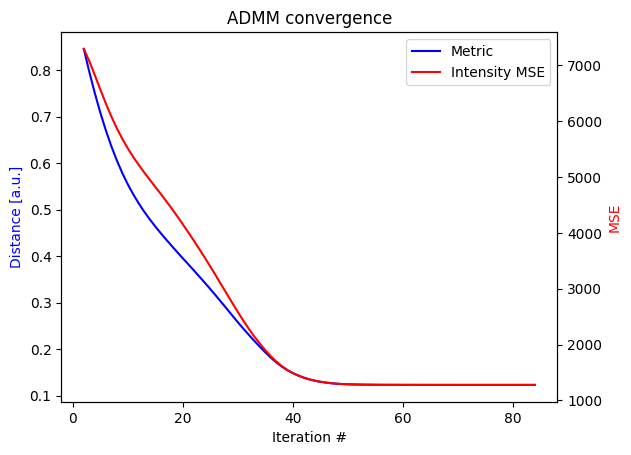

In [11]:
tmr = TMR(A, B, verbose=False, device='cuda')
tmr.run_admm(max_iter=100, lr=1e-2, tol=1e-7, rho=1)
tmr.show_results()

## Phase retrieval attempt using ADMM and the transfer matrix recovered using ADMM

Iteration:   1 - distance = 2.980e+01 - stopping distance = 7.419e+01
Iteration:   2 - distance = 2.972e-01 - stopping distance = 2.951e+01
Iteration:   3 - distance = 2.231e-01 - stopping distance = 7.416e-02
Iteration:   4 - distance = 2.247e-01 - stopping distance = 1.643e-03
Iteration:   5 - distance = 2.260e-01 - stopping distance = 1.266e-03
Iteration:   6 - distance = 2.217e-01 - stopping distance = 4.295e-03
Iteration:   7 - distance = 2.232e-01 - stopping distance = 1.530e-03
Iteration:   8 - distance = 2.242e-01 - stopping distance = 9.958e-04
Iteration:   9 - distance = 2.247e-01 - stopping distance = 5.268e-04
Iteration:  10 - distance = 2.239e-01 - stopping distance = 8.127e-04
Iteration:  11 - distance = 2.267e-01 - stopping distance = 2.744e-03
Iteration:  12 - distance = 2.265e-01 - stopping distance = 2.047e-04
Iteration:  13 - distance = 2.288e-01 - stopping distance = 2.331e-03
Iteration:  14 - distance = 2.272e-01 - stopping distance = 1.566e-03
Iteration:  15 - dis

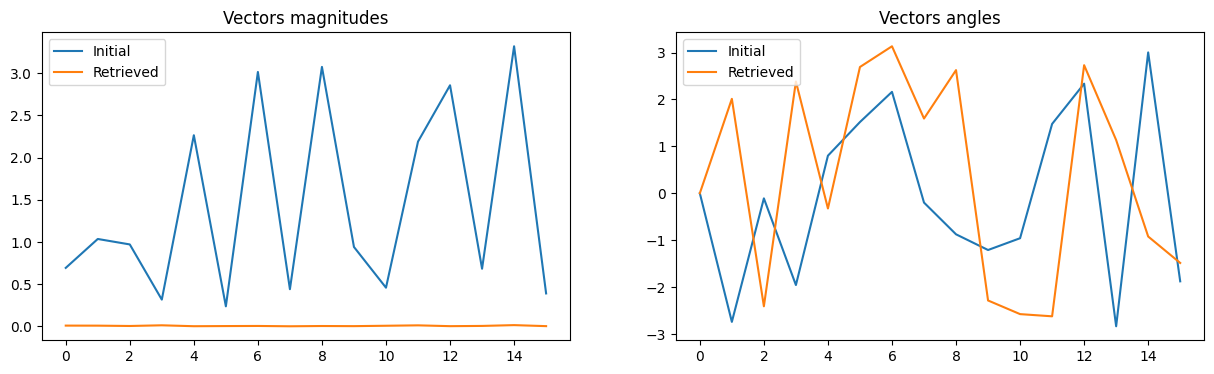

In [13]:
tm = tmr.X_best.T
x0 = np.random.randn(A.shape[1],1) + 1j * np.random.randn(A.shape[1],1)
b = np.abs(np.dot(tm, x0))
b = b / np.max(b)
b = np.sqrt( np.abs(np.square(b) + 0.05*np.random.rand(b.shape[0])))


x = admm_pr(tm, b, rho=1, max_iter=100, max_inner_iter=100, tol=1e-7, lr=1e-2, verbose=1, device='cuda')
x = x.cpu().detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(15,4))
axs[0].plot(np.abs(x0), label='Initial')
axs[0].plot(np.abs(x), label='Retrieved')
axs[0].set_title('Vectors magnitudes')
axs[0].legend()

axs[1].plot(np.angle(np.exp(1j * (np.angle(x0)-np.angle(x0[0])))), label='Initial')
axs[1].plot(np.angle(np.exp(1j * (np.angle(x)-np.angle(x[0])))), label='Retrieved')
axs[1].set_title('Vectors angles')
axs[1].legend()

## Compare estimated matrices with the old one

[(-0.5, 15.5, 63.5, -0.5),
 (-0.5, 15.5, 63.5, -0.5),
 (-0.5, 15.5, 63.5, -0.5),
 (-0.5, 15.5, 63.5, -0.5)]

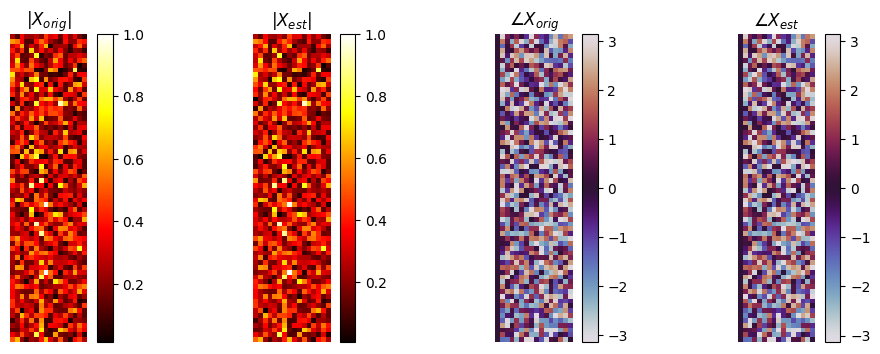

In [14]:
titles = [r"$|X_{orig}|$", r"$|X_{est}|$", r"$\angle X_{orig}$", r"$\angle X_{est}$"]
pls = []

fig, axs = plt.subplots(1, 4, figsize=(12,4))
pls.append(axs[0].imshow(np.abs(X), cmap="hot"))
pls.append(axs[1].imshow(np.abs(tmr.X_norm.T), cmap="hot"))
pls.append(axs[2].imshow(np.angle(X), cmap="twilight"))
pls.append(axs[3].imshow(np.angle(tmr.X_norm.T), cmap="twilight"))
[ plt.colorbar(pls[i], ax=axs[i]) for i in range(len(pls)) ]
[ axs[i].set_title(titles[i]) for i in range(len(pls)) ]
[ axs[i].axis('off') for i in range(len(pls)) ]

[(-0.5, 15.5, 63.5, -0.5), (-0.5, 15.5, 63.5, -0.5)]

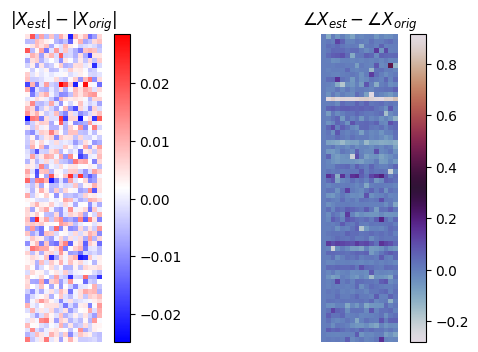

In [16]:
titles = [r"$|X_{est}| - |X_{orig}|$", r"$\angle X_{est} - \angle X_{orig}$"]
pls = []

fig, axs = plt.subplots(1, 2, figsize=(7,4))
pls.append(axs[0].imshow(np.abs(tmr.X_norm.T) - np.abs(X), cmap="bwr"))
pls.append(axs[1].imshow(np.angle(np.exp(1j * (np.angle(tmr.X_norm.T) - np.angle(X)))), cmap="twilight"))
[ plt.colorbar(pls[i], ax=axs[i]) for i in range(len(pls)) ]
[ axs[i].set_title(titles[i]) for i in range(len(pls)) ]
[ axs[i].axis('off') for i in range(len(pls)) ]

# Compare outputs from retrieved matrices with measured outputs

[(-0.5, 63.5, 349.5, -0.5),
 (-0.5, 63.5, 349.5, -0.5),
 (-0.5, 63.5, 349.5, -0.5)]

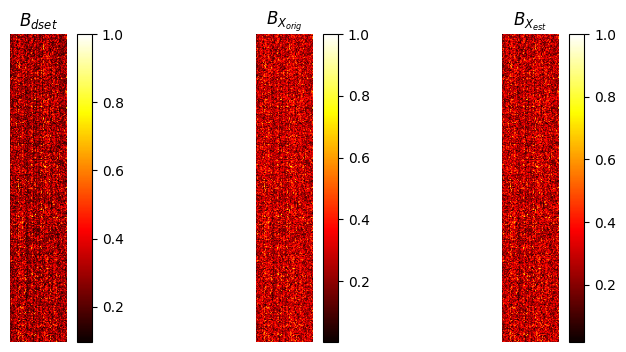

In [18]:
B_X = np.abs(np.dot(A, X.T))
B_X1 = np.abs(np.dot(A, tmr.X_norm))

titles = [r"$B_{dset}$", r"$B_{X_{orig}}$", r"$B_{X_{est}}$"]
pls = []

fig, axs = plt.subplots(1, 3, figsize=(9,4))
pls.append(axs[0].imshow(B / np.max(B), cmap="hot"))
pls.append(axs[1].imshow(B_X / np.max(B_X), cmap="hot"))
pls.append(axs[2].imshow(B_X1 / np.max(B_X1), cmap="hot"))
[ plt.colorbar(pls[i], ax=axs[i]) for i in range(len(pls)) ]
[ axs[i].set_title(titles[i]) for i in range(len(pls)) ]
[ axs[i].axis('off') for i in range(len(pls)) ]

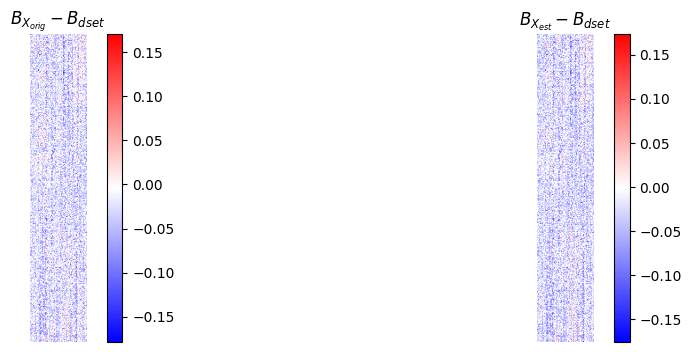

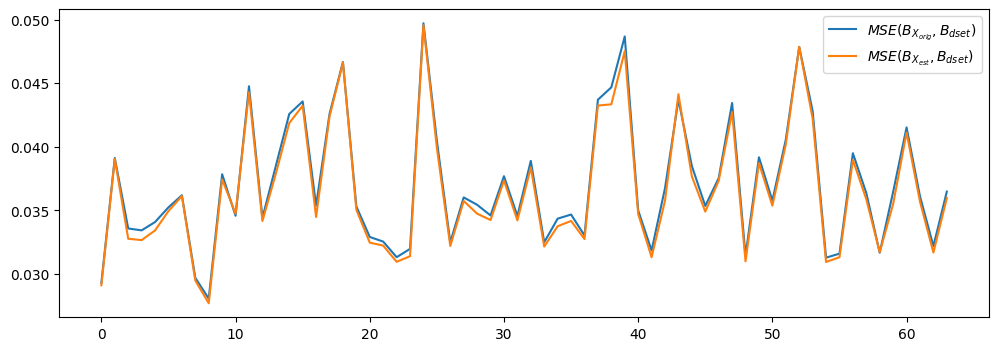

In [19]:
titles = [r"$B_{X_{orig}} - B_{dset}$", r"$B_{X_{est}} - B_{dset}$"]
pls = []

fig, axs = plt.subplots(1, 2, figsize=(12,4))
pls.append(axs[0].imshow(B_X / np.max(B_X) - B / np.max(B), cmap="bwr"))
pls.append(axs[1].imshow(B_X1 / np.max(B_X1) - B / np.max(B), cmap="bwr"))
[ plt.colorbar(pls[i], ax=axs[i]) for i in range(len(pls)) ]
[ axs[i].set_title(titles[i]) for i in range(len(pls)) ]
[ axs[i].axis('off') for i in range(len(pls)) ]


titles = [r"$B_{X_{orig}} - B_{dset}$", r"$B_{X_{est}} - B_{dset}$"]
pls = []

mse_B_X = np.mean(np.abs(B_X / np.max(B_X) - B / np.max(B)), axis=0)
mse_B_X1 = np.mean(np.abs(B_X1 / np.max(B_X1) - B / np.max(B)), axis=0)

fig = plt.figure(figsize=(12,4))
plt.plot(mse_B_X, label=r"$MSE(B_{X_{orig}}, B_{dset})$")
plt.plot(mse_B_X1, label=r"$MSE(B_{X_{est}}, B_{dset})$")
plt.legend()

## Compare inverted matrices and resulting phase maps

[(-0.5, 349.5, 15.5, -0.5),
 (-0.5, 349.5, 15.5, -0.5),
 (-0.5, 349.5, 15.5, -0.5),
 (-0.5, 349.5, 15.5, -0.5),
 (-0.5, 349.5, 15.5, -0.5),
 (-0.5, 349.5, 15.5, -0.5)]

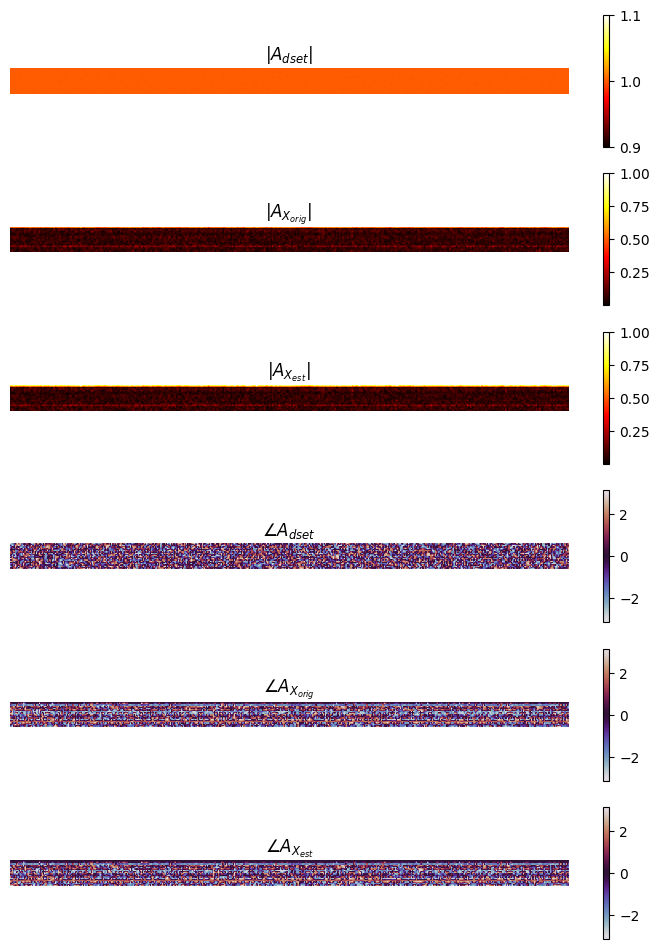

In [9]:
X_pinv = np.linalg.pinv(X.T)
X1_pinv = np.linalg.pinv(tmr.X_norm)

A_X = np.dot(B_X, X_pinv)
A_X1 = np.dot(B_X1, X1_pinv)

A_X = A_X / np.max(np.abs(A_X))
A_X1 = A_X1 / np.max(np.abs(A_X1))

titles = [r"$|A_{dset}|$", r"$|A_{X_{orig}}|$", r"$|A_{X_{est}}|$",
          r"$\angle A_{dset}$", r"$\angle A_{X_{orig}}$", r"$\angle A_{X_{est}}$"]
pls = []

fig, axs = plt.subplots(6, 1, figsize=(9,12))
pls.append(axs[0].imshow(np.abs(A.T), cmap="hot"))
pls.append(axs[1].imshow(np.abs(A_X.T), cmap="hot"))
pls.append(axs[2].imshow(np.abs(A_X1.T), cmap="hot"))
pls.append(axs[3].imshow(np.angle(A.T), cmap="twilight"))
pls.append(axs[4].imshow(np.angle(A_X.T), cmap="twilight"))
pls.append(axs[5].imshow(np.angle(A_X1.T), cmap="twilight"))
[ plt.colorbar(pls[i], ax=axs[i]) for i in range(len(pls)) ]
[ axs[i].set_title(titles[i]) for i in range(len(pls)) ]
[ axs[i].axis('off') for i in range(len(pls)) ]

[(-0.5, 349.5, 15.5, -0.5),
 (-0.5, 349.5, 15.5, -0.5),
 (-0.5, 349.5, 15.5, -0.5),
 (-0.5, 349.5, 15.5, -0.5)]

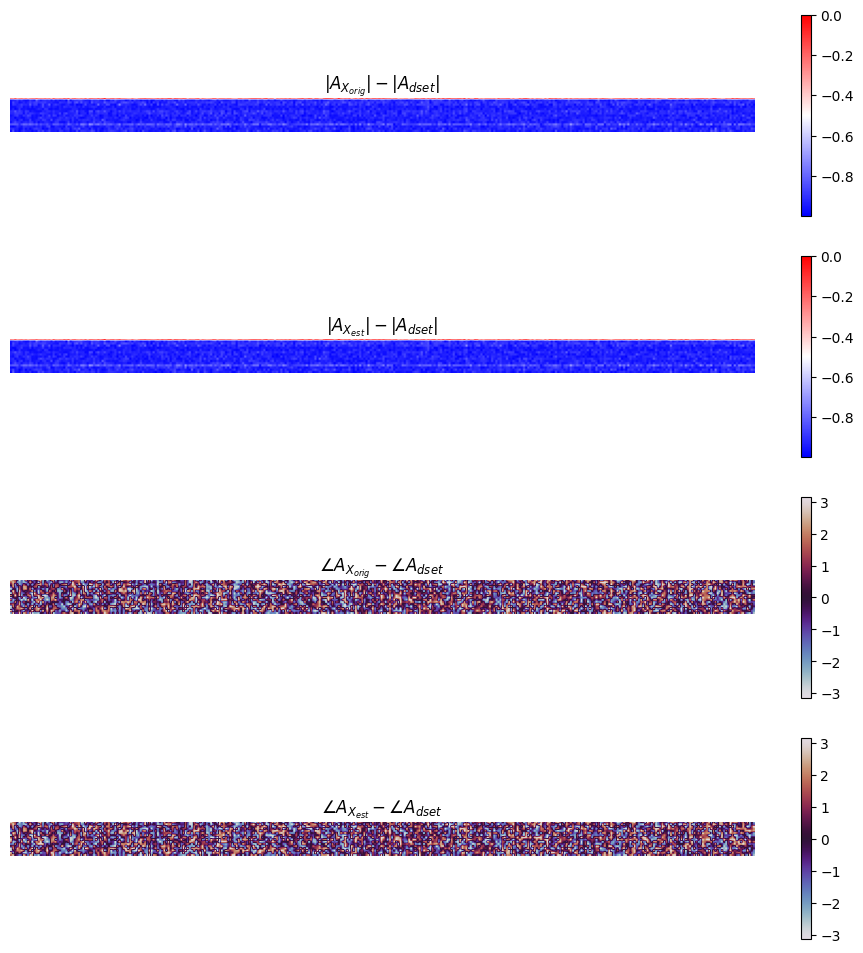

In [10]:
titles = [r"$|A_{X_{orig}}| - |A_{dset}|$", r"$|A_{X_{est}}| - |A_{dset}|$",
          r"$\angle A_{X_{orig}} - \angle A_{dset}$", r"$\angle A_{X_{est}} - \angle A_{dset}$"]
pls = []

fig, axs = plt.subplots(4, 1, figsize=(12,12))
pls.append(axs[0].imshow(np.abs(A_X.T) - np.abs(A.T), cmap="bwr"))
pls.append(axs[1].imshow(np.abs(A_X1.T) - np.abs(A.T), cmap="bwr"))
pls.append(axs[2].imshow(np.angle(np.exp(1j * (np.angle(A_X.T) - np.angle(A.T)))), cmap="twilight"))
pls.append(axs[3].imshow(np.angle(np.exp(1j * (np.angle(A_X1.T) - np.angle(A.T)))), cmap="twilight"))
[ plt.colorbar(pls[i], ax=axs[i]) for i in range(len(pls)) ]
[ axs[i].set_title(titles[i]) for i in range(len(pls)) ]
[ axs[i].axis('off') for i in range(len(pls)) ]

## Compare outputs from inverted phases

Do it for only one case (randomly drawn from the dataset) for easier readability

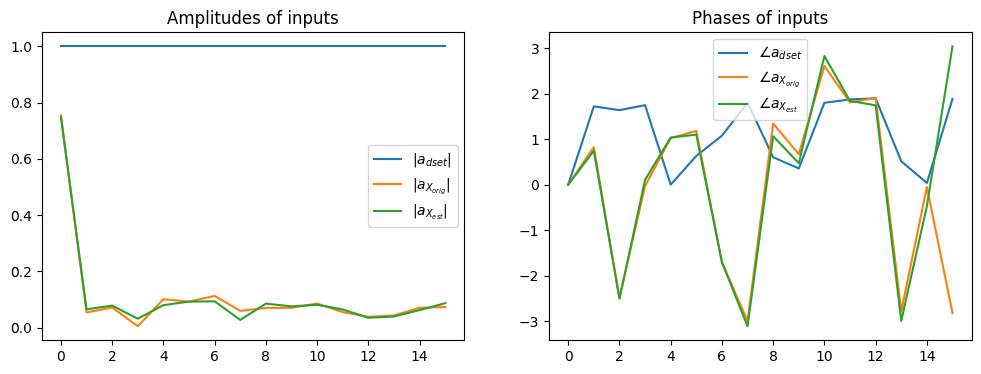

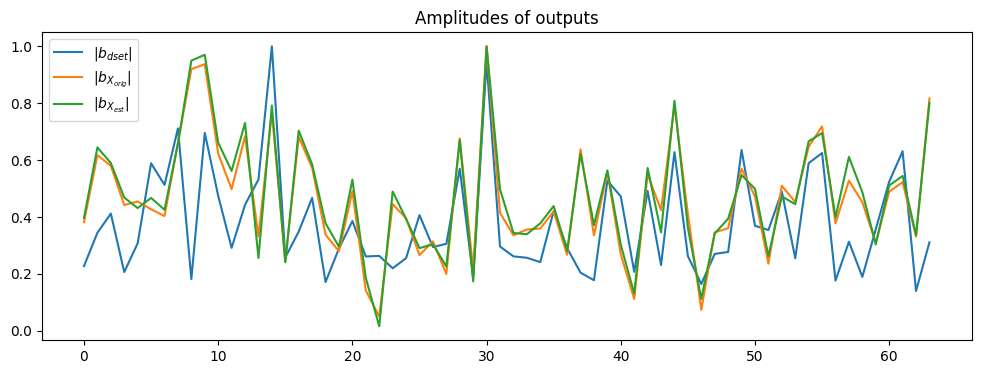

In [13]:
idx = np.random.randint(0, A.shape[0])

a = A[idx, :]
a_X = A_X[idx, :]
a_X1 = A_X1[idx, :]


b = B[idx, :]
b_X = np.abs(np.dot(X, a_X))
b_X1 = np.abs(np.dot(X, a_X1))


fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(np.abs(a), label=r"$|a_{dset}|$")
axs[0].plot(np.abs(a_X), label=r"$|a_{X_{orig}}|$")
axs[0].plot(np.abs(a_X1), label=r"$|a_{X_{est}}|$")
axs[1].plot(np.angle(np.exp(1j * (a - a[0]))), label=r"$\angle a_{dset}$")
axs[1].plot(np.angle(np.exp(1j * (np.angle(a_X) - np.angle(a_X[0])))), label=r"$\angle a_{X_{orig}}$")
axs[1].plot(np.angle(np.exp(1j * (np.angle(a_X1) - np.angle(a_X1[0])))), label=r"$\angle a_{X_{est}}$")
axs[0].set_title('Amplitudes of inputs')
axs[1].set_title('Phases of inputs')
axs[0].legend()
axs[1].legend()


fig = plt.figure(figsize=(12,4))
ax = plt.gca()
ax.plot(np.abs(b) / np.max(b), label=r"$|b_{dset}|$")
ax.plot(np.abs(b_X) / np.max(b_X), label=r"$|b_{X_{orig}}|$")
ax.plot(np.abs(b_X1) / np.max(b_X1), label=r"$|b_{X_{est}}|$")
ax.set_title('Amplitudes of outputs')
ax.legend()